## Imports

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)

## Preprocessing

In [26]:
df = pd.read_csv("data/healthcare-dataset-stroke-data.csv")

# drop id column
df = df.drop(columns=["id"])

# fill missing bmi values
df["bmi"] = df["bmi"].fillna(df["bmi"].median())

# one-hot encode categorical columns
cat_cols = ["gender", "ever_married", "work_type", "Residence_type", "smoking_status"]
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# scale numeric columns
num_cols = ["age", "avg_glucose_level", "bmi"]
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# split into features and labels
X = df.drop(columns=["stroke"])
y = df["stroke"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("X_train Shape: ",X_train.shape)
print("X_test Shape: ",X_test.shape)
print()
print("y_test Class counts:", y_test.value_counts())
print()
print("y_train Class counts:", y_train.value_counts())


X_train Shape:  (4088, 16)
X_test Shape:  (1022, 16)

y_test Class counts: stroke
0    972
1     50
Name: count, dtype: int64

y_train Class counts: stroke
0    3889
1     199
Name: count, dtype: int64


## Data Visualization

Stroke class counts:  stroke
0    4861
1     249
Name: count, dtype: int64


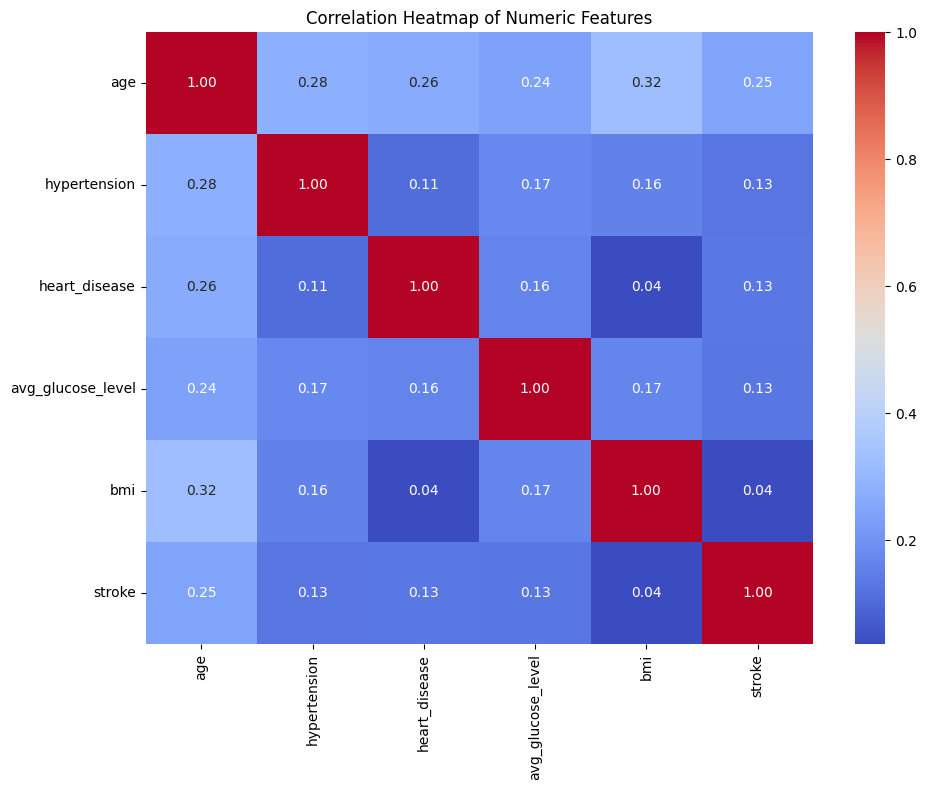

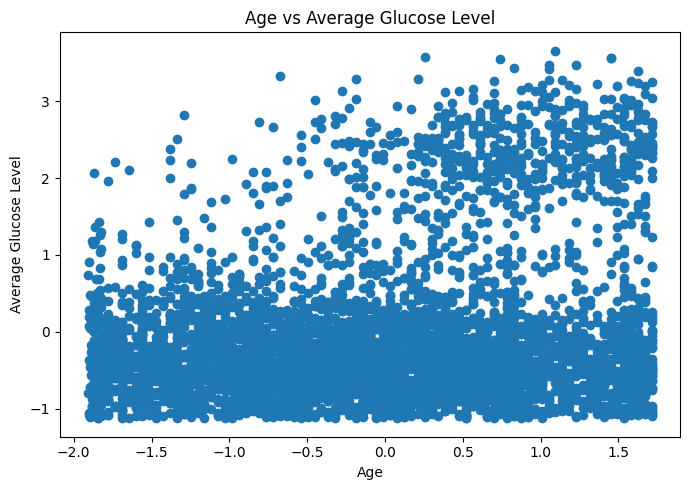

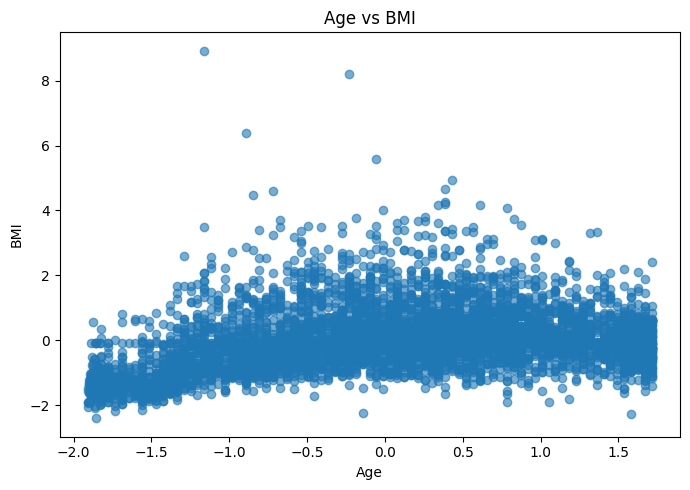

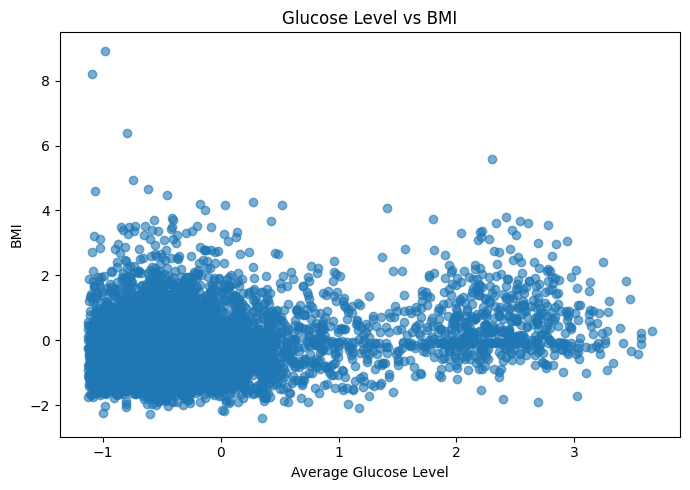

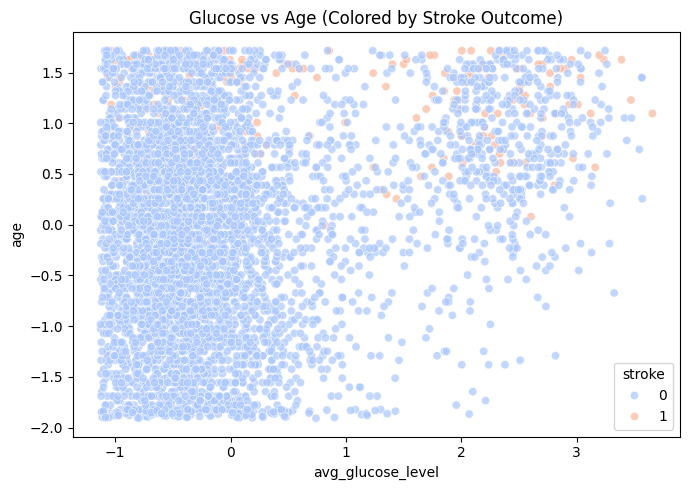

In [27]:
print("Stroke class counts: ",df['stroke'].value_counts())

#   1. CORRELATION HEATMAP
# Only keep numeric columns
numeric_df = df.select_dtypes(include=["float64", "int64"])

plt.figure(figsize=(10, 8))
sns.heatmap(numeric_df.corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

#   2. SCATTER PLOTS vs AGE
plt.figure(figsize=(7,5))
plt.scatter(df["age"], df["avg_glucose_level"])
plt.xlabel("Age")
plt.ylabel("Average Glucose Level")
plt.title("Age vs Average Glucose Level")
plt.tight_layout()
plt.show()

plt.figure(figsize=(7,5))
plt.scatter(df["age"], df["bmi"], alpha=0.6)
plt.xlabel("Age")
plt.ylabel("BMI")
plt.title("Age vs BMI")
plt.tight_layout()
plt.show()

#   3. SCATTER PLOTS vs GLUCOSE
plt.figure(figsize=(7,5))
plt.scatter(df["avg_glucose_level"], df["bmi"], alpha=0.6)
plt.xlabel("Average Glucose Level")
plt.ylabel("BMI")
plt.title("Glucose Level vs BMI")
plt.tight_layout()
plt.show()

# If you want to compare to stroke outcome:
plt.figure(figsize=(7,5))
sns.scatterplot(
    data=df,
    x="avg_glucose_level",
    y="age",
    hue="stroke",
    palette="coolwarm",
    alpha=0.7
)
plt.title("Glucose vs Age (Colored by Stroke Outcome)")
plt.tight_layout()
plt.show()

## Modeling

In [75]:
#logistic regression
log_reg = LogisticRegression(
    max_iter=1000,
    class_weight={0:1,1:15},   # helps with stroke class imbalance
    random_state=42
)
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_proba_lr = log_reg.predict_proba(X_test)[:, 1]

print("=== Logistic Regression ===")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))

#random forest
rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    class_weight="balanced",
    random_state=42
)
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_proba_rf = rf.predict_proba(X_test)[:, 1]

print("\n=== Random Forest ===")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("ROC-AUC:", roc_auc_score(y_test, y_proba_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))

=== Logistic Regression ===
Accuracy: 0.7886497064579256
ROC-AUC: 0.8437242798353909

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.79      0.88       972
           1       0.16      0.80      0.27        50

    accuracy                           0.79      1022
   macro avg       0.57      0.79      0.57      1022
weighted avg       0.95      0.79      0.85      1022

Confusion Matrix:
 [[766 206]
 [ 10  40]]

=== Random Forest ===
Accuracy: 0.9500978473581213
ROC-AUC: 0.7977366255144033

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       972
           1       0.00      0.00      0.00        50

    accuracy                           0.95      1022
   macro avg       0.48      0.50      0.49      1022
weighted avg       0.90      0.95      0.93      1022

Confusion Matrix:
 [[971   1]
 [ 50   0]]


## Evaluation

Logistic Regression Confusion Matrix:


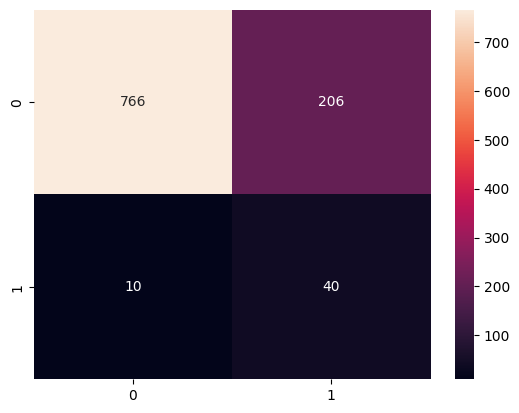

Random Forest Classifier Confusion Matrix:


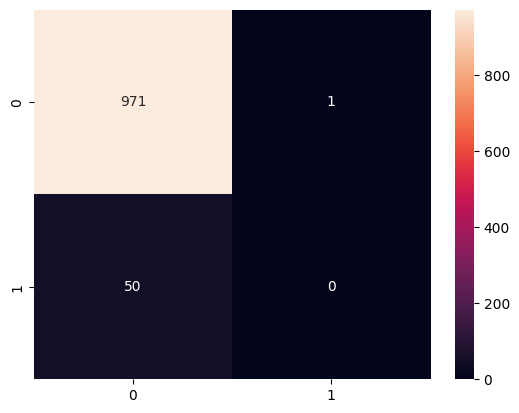

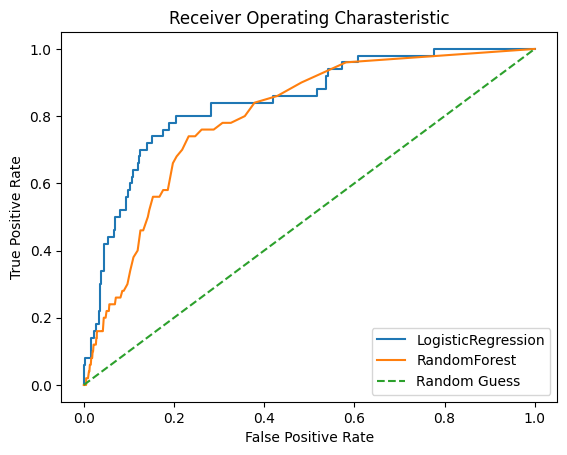

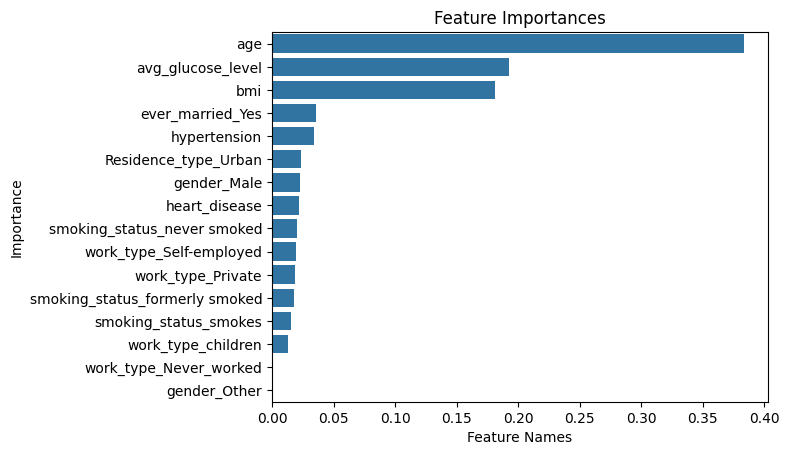

In [76]:
#logistic regression
print("Logistic Regression Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt="d")
plt.show()

#random forest
print("Random Forest Classifier Confusion Matrix:")
sns.heatmap(confusion_matrix(y_test, y_pred_rf), annot=True, fmt="d")
plt.show()

#roc curves
fpr, tpr, _ = roc_curve(y_test, y_proba_lr, pos_label=1)
plt.plot(fpr, tpr, label="LogisticRegression")

fpr, tpr, _ = roc_curve(y_test, y_proba_rf, pos_label=1)
plt.plot(fpr, tpr, label="RandomForest")

plt.plot([0,1],[0,1],label="Random Guess", linestyle='dashed')
plt.title('Receiver Operating Charasteristic')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()

## Feature importances
importances = pd.DataFrame({"feature":X.columns,"importance":rf.feature_importances_}).sort_values(by="importance", ascending=False)
sns.barplot(importances, x="importance", y="feature")
plt.title("Feature Importances")
plt.xlabel("Feature Names")
plt.ylabel("Importance")
plt.show()